# Inverting 

1. Figure out how to convert spectral data to RGB.
2. Make the color mixing model. 

In [1]:
# Download data
from subprocess import call 
import os
import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from skimage.color import xyz2rgb
from shapely.geometry import *

DATA_DIR = '/tmp/'
D65_FILE = osp.join(DATA_DIR, 'std65.txt')

PAINT_URL = 'https://www.azadehasadi.com/publication_files/spectralDatasets.zip'
D65_URL = 'https://web.archive.org/web/20171122140854/http://www.cie.co.at/publ/abst/datatables15_2004/std65.txt'

call(['wget', PAINT_URL, '-P', DATA_DIR])
call(['unzip', osp.join(DATA_DIR, 'spectralDatasets.zip'), '-d', DATA_DIR])
call(['wget', D65_URL, '-P', DATA_DIR])

--2022-02-07 17:26:54--  https://www.azadehasadi.com/publication_files/spectralDatasets.zip
Resolving www.azadehasadi.com (www.azadehasadi.com)... 2606:50c0:8003::153, 2606:50c0:8000::153, 2606:50c0:8002::153, ...
Connecting to www.azadehasadi.com (www.azadehasadi.com)|2606:50c0:8003::153|:443... failed: No route to host.
Connecting to www.azadehasadi.com (www.azadehasadi.com)|2606:50c0:8000::153|:443... failed: No route to host.
Connecting to www.azadehasadi.com (www.azadehasadi.com)|2606:50c0:8002::153|:443... failed: No route to host.
Connecting to www.azadehasadi.com (www.azadehasadi.com)|2606:50c0:8001::153|:443... failed: No route to host.
Connecting to www.azadehasadi.com (www.azadehasadi.com)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64147 (63K) [application/zip]
Saving to: ‘/tmp/spectralDatasets.zip.4’

     0K .......... .......... .......... .......... .......... 79%  977K 0s
    50K .......... ..                               

Archive:  /tmp/spectralDatasets.zip


207.241.237.3
Connecting to web.archive.org (web.archive.org)|207.241.237.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899 (1.9K) [text/plain]
Saving to: ‘/tmp/std65.txt.4’

     0K .                                                     100% 73.5M=0s

2022-02-07 17:27:00 (73.5 MB/s) - ‘/tmp/std65.txt.4’ saved [1899/1899]



0

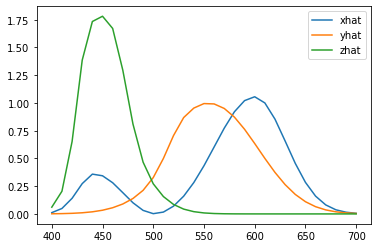

In [2]:
# Specify the XYZ color matching functions
def pwGaussian(mu, sigma1, sigma2) :
    def fn (x) :
        if x < mu : 
            return np.exp((-0.5 * (x - mu) ** 2) / (sigma1 ** 2))
        else :
            return np.exp((-0.5 * (x - mu) ** 2) / (sigma2 ** 2))
    return fn

def weightedGaussian (wts, mus, s1s, s2s) :
    fns = list(map(pwGaussian, mus, s1s, s2s))
    def fn(x) : 
        evals = [f(x) for f in fns]
        return sum(map(lambda x, y: x * y, wts, evals))
    return fn

# Obtained these numbers from wikipedia - CIE_1931_color_space
xhat = weightedGaussian(
    wts=[1.056, 0.362, -0.065], 
    mus=[599.8, 442.0, 501.1],
    s1s=[37.9, 16.0, 20.4],
    s2s=[31.0, 26.7, 26.2]
)
yhat = weightedGaussian(
    wts=[0.821, 0.286],
    mus=[568.8, 530.9],
    s1s=[46.9, 16.3],
    s2s=[40.5, 31.1]
)
zhat = weightedGaussian(
    wts=[1.217, 0.681],
    mus=[437.0, 459.0],
    s1s=[11.8, 26.0],
    s2s=[36.0, 13.8]
)

ws = np.linspace(400, 700, 31).astype(int)
x = [xhat(_) for _ in ws] 
y = [yhat(_) for _ in ws] 
z = [zhat(_) for _ in ws] 
plt.plot(ws, x, label='xhat')
plt.plot(ws, y, label='yhat')
plt.plot(ws, z, label='zhat')
plt.legend()
plt.show()

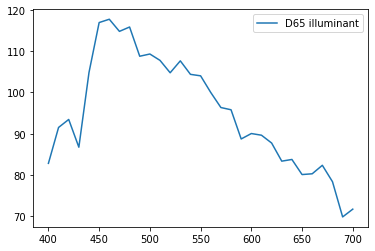

In [3]:
# Plot the D65 illuminant distribution 
d65_df = pd.read_csv(D65_FILE, delimiter=r'\s+', skiprows=1, header=None)
d65 = dict(zip(list(d65_df[0]), [float(_.replace(',', '.')) for _ in d65_df[1]]))
plt.plot(ws, [d65[_] for _ in ws], label='D65 illuminant')
plt.legend()
plt.show()

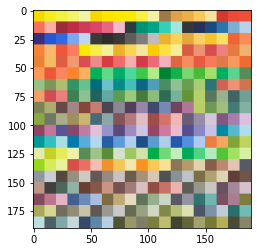

In [4]:
def integrate(x, y) : 
    poly = Polygon([(x[0], 0), *list(zip(x, y)), (x[-1], 0)])
    a = [(x[0], 0), *list(zip(x, y)), (x[-1], 0)]
    return poly.area

def spectrum2rgb (spectrum) :
    xs = [xhat(_) for _ in ws]
    ys = [yhat(_) for _ in ws]
    zs = [zhat(_) for _ in ws] 
    illuminant = [d65[_] for _ in ws]
    N = integrate(ws, [a * b for a, b in zip(ys, illuminant)])
    K = 1
    X = K * integrate(ws, [a * b * c for a, b, c in zip(xs, spectrum, illuminant)]) / N
    Y = K * integrate(ws, [a * b * c for a, b, c in zip(ys, spectrum, illuminant)]) / N
    Z = K * integrate(ws, [a * b * c for a, b, c in zip(zs, spectrum, illuminant)]) / N 
    return xyz2rgb([X, Y, Z]) 

watercolors = pd.read_csv(osp.join(DATA_DIR, 'watercolorspectra.txt'), header=None, delimiter=r'\s+') 

im = np.ones((190, 190, 3))
for i in range(19) :
    for j in range(19):     
        im[10 * i:10 * (i + 1), 10 * j:10 * (j + 1)] = np.array(spectrum2rgb(list(watercolors.iloc[i * 19 + j])))
plt.imshow(im)
plt.show()

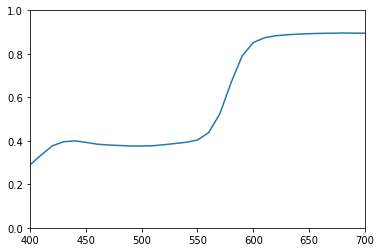

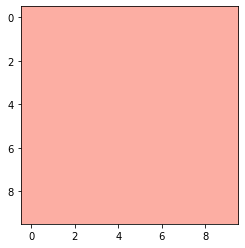

In [5]:
def plotSpectrum(spectrum): 
    ws = np.linspace(400, 700, 31)
    plt.plot(ws, list(spectrum))
    plt.xlim(400, 700)
    plt.ylim(0, 1)
    plt.show()
    im = np.ones((10, 10, 3))
    im[:, :] = np.array(spectrum2rgb(spectrum))
    plt.imshow(im)
    plt.show()
    
plotSpectrum(watercolors.iloc[20])